# A K-means clustering project

The purpose of this exercise is to implement the K-means clustering module of pyspark and find how many hacker groups were involved in the data brach of a certain technology firm. The forensic engineers of the firm were able to collect some meta data of each brach. The firm suspects that there might be two or three hacker group. But they are sure that each group attacked the same number of times, i.e. the attack from the hacker groups was 50 - 50. 

In [1]:
import findspark
findspark.init('/home/yohannes/spark-2.4.7-bin-hadoop2.7')
%config Completer.use_jedi = False

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('Kmeans').getOrCreate()

In [4]:
data = spark.read.csv('hack_data.csv',header=True,inferSchema=True)

### Data exploration

In [5]:
data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [6]:
data.head(1)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37)]

### Creating features vector

In [7]:
from pyspark.ml.feature import VectorAssembler

In [8]:
data.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [9]:
assembler = VectorAssembler(inputCols=['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'], outputCol='features')

In [10]:
final_data = assembler.transform(data)

In [11]:
final_data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)



### Scaling the data

In [12]:
from pyspark.ml.feature import StandardScaler

In [13]:
scaler = StandardScaler(inputCol='features',outputCol='scaledFeat')

In [14]:
final_data = scaler.fit(final_data).transform(final_data)

In [15]:
final_data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)



### K-means clustering model

In [16]:
from pyspark.ml.clustering import KMeans

In [68]:
# let's try with the assumption that there were two hacker groups
kmeans = KMeans(featuresCol='scaledFeat',k=2)

In [69]:
model = kmeans.fit(final_data)

In [70]:
results = model.transform(final_data)

In [71]:
centers = model.clusterCenters()

In [72]:
print(centers)

[array([2.99991988, 2.92319035, 1.05261534, 3.20390443, 4.51321315,
       3.28474   ]), array([1.26023837, 1.31829808, 0.99280765, 1.36491885, 2.5625043 ,
       5.26676612])]


In [73]:
results.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [74]:
results.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|        prediction|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|               0.5|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|0.5007501879687625|
|    min|                    1.0|             

In [80]:
results.groupBy('prediction').count().show()
# This shows that the attack was equaly sheared by the hacker groups

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



### Graphical visualization of the clusters

In [75]:
results_pd = results.toPandas()

In [76]:
results_pd

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed,features,scaledFeat,prediction
0,8.0,391.09,1,2.96,7.0,Slovenia,72.37,"[8.0, 391.09, 1.0, 2.96, 7.0, 72.37]","[0.5678510846650524, 1.3658432518957642, 1.997...",1
1,20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08,"[20.0, 720.99, 0.0, 3.04, 9.0, 69.08]","[1.419627711662631, 2.517986463945197, 0.0, 1....",1
2,31.0,356.32,1,3.71,8.0,Tokelau,70.58,"[31.0, 356.32, 1.0, 3.71, 8.0, 70.58]","[2.2004229530770782, 1.2444124562517545, 1.997...",1
3,2.0,228.08,1,2.48,8.0,Bolivia,70.80,"[2.0, 228.08, 1.0, 2.48, 8.0, 70.8]","[0.1419627711662631, 0.7965469045293562, 1.997...",1
4,20.0,408.50,0,3.57,8.0,Iraq,71.28,"[20.0, 408.5, 0.0, 3.57, 8.0, 71.28]","[1.419627711662631, 1.4266459597520256, 0.0, 1...",1
5,1.0,390.69,1,2.79,9.0,Marshall Islands,71.57,"[1.0, 390.69, 1.0, 2.79, 9.0, 71.57]","[0.07098138558313155, 1.3644462913476594, 1.99...",1
6,18.0,342.97,1,5.10,7.0,Georgia,72.32,"[18.0, 342.97, 1.0, 5.1, 7.0, 72.32]","[1.277664940496368, 1.197788897958757, 1.99757...",1
7,22.0,101.61,1,3.03,7.0,Timor-Leste,72.03,"[22.0, 101.61, 1.0, 3.03, 7.0, 72.03]","[1.561590482828894, 0.35486290323232145, 1.997...",1
8,15.0,275.53,1,3.53,8.0,Palestinian Territory,70.17,"[15.0, 275.53, 1.0, 3.53, 8.0, 70.17]","[1.0647207837469732, 0.9622613495482878, 1.997...",1
9,12.0,424.83,1,2.53,8.0,Bangladesh,69.99,"[12.0, 424.83, 1.0, 2.53, 8.0, 69.99]","[0.8517766269975786, 1.4836768741284039, 1.997...",1


In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Bytes Transferred')

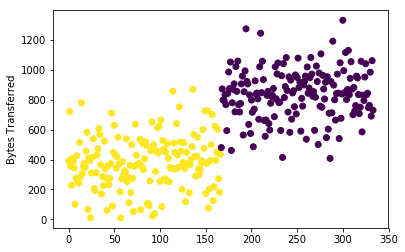

In [87]:
plot = plt.scatter(data=results_pd, x=results_pd.index, y=results_pd['Bytes Transferred'],c=results_pd['prediction'])
plt.ylabel('Bytes Transferred')